In [1]:
include("../scripts/mcl.jl")

draw (generic function with 7 methods)

In [3]:
mutable struct GlobalMcl <: AbstractMcl
    particles
    map
    distance_dev_rate
    direction_dev
    motion_noise_rate_pdf
    ml
    pose
end

In [16]:
function GlobalMcl_(envmap, init_pose, num, motion_noise_stds=Dict("nn"=>0.19, "no"=>0.001, "on"=>0.13, "oo"=>0.2),
        distance_dev_rate=0.14, direction_dev=0.05)
    self = GlobalMcl(ntuple(x->nothing, fieldcount(GlobalMcl))...)
    self.particles =[Particle(init_pose, 1.0/num) for i in 1:num-1]
    self.map = envmap
    self.distance_dev_rate = distance_dev_rate
    self.direction_dev = direction_dev
    v = motion_noise_stds
    c = Diagonal([v["nn"]^2, v["no"]^2, v["on"]^2, v["oo"]^2])
    self.motion_noise_rate_pdf = MvNormal(zeros(4), c)
    self.ml = self.particles[1]
    self.pose = self.ml.pose
    for p in self.particles
        p.pose = [rand(Uniform(-5.0, 5.0)), rand(Uniform(-5.0, 5.0)), rand(Uniform(-pi, pi))]
    end
    return self
end

GlobalMcl_ (generic function with 4 methods)

In [19]:
function trial(animation)
    time_interval = 1.0
    world = World_(30, time_interval, animation)
    
    m = Map()
    for ln in [[-4.0, 2.0], [2.0, -3.0], [3.0, 3.0]]
        append_landmark(m, Landmark(ln))
    end
    append(world, m)
    
    initial_pose = [rand(Uniform(-5.0, 5.0)), rand(Uniform(-5.0, 5.0)), rand(Uniform(-pi, pi))]
    pf = GlobalMcl_(m, initial_pose, 100)
    a = EstimationAgent_(time_interval, 0.2, 10.0/180*pi, pf)
    r = Robot_(initial_pose, sensor=Camera_(m), agent=a, color="red")
    append(world, r)
    draw(world)
    showanim("test.mp4")
    return r.pose, pf.pose
end

trial (generic function with 1 method)

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQADP3FtZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1NyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTggLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAARpxliIQAF//+99S3zLLtU2+2C6j3op4mX0N1JQGblsTtOoAAAAMAAAMAAB68FzgCX4kK868AAAMAyoAXqEn/CmOPiA7BC5NJlvfhKIWPSXi/zA6JYDLoQAMQkginty7NGv2twoUk3+x++sOjdyFuzv1cWbQ24zhAwD/CCSRR5+vZ0lAZdoq1bzGMjn4s5Ed2Kxl3/7H+f7ZCSBIEmftsotyU+v6r0UGfhGGV3NUjIp090poW1MbfZW4sf2v8wEqyMq6YFvN4gyComVLD44fHZ1ovllleQzCA6GwlSb6tqkhP78iPCBe0OctpLjnBE3oKrwYqahstB0fRDRXhon++fNZYe4Iv/Q5ciRJ+lr4l/3WEy+nDz15h8WM/uXpRJ1hNCBn4YLcb8iVhFg+w9uNH/7csSZneL9thpyUa4F7eVUTCZiYoMUABoeNc0uqHL/BCY7bxzohmPCPPV7oTer+ldXeKYh/yckKr7secWGOaEQ8pzQashmsbaAdv2FZsT2cmBK7NcfsyMJjCTKS8bzyRHiqQNatmTnFZToOjunX1oX6udRNx4q1y1sxZ4NgfI9fLrTh9gWpvEP0lYYROq9O4cKTgcjv+b4nV3Z8XLvJdjczVDzkxmOA6zf4TTlMQ7Xcx8XDdyrCI5SPz2UYP0MzLeXq7kkWu0cK7cnS9Xd2BBkbvE234SWb92cXkAsx2nWrwus0w2eonbSudo6NqRbr6xfXsWT55PgbhVPvGxpB5kEZIFawwx78xF2NbEtAshLFFXAcCK4xPjK771IFbRMi6LpPAgXqPstYAfKAYrmIBYgJWsFJ6xp+Z3oyjEPH0zoHIn+JThr1mdQV1C11yNiLTt8BASRKZ/luW72z9pYp9erm493+pbOyLC6hIu+ANjHcl89lMm5s9uTHQORqOK2sEILJ2ARaErflMvhT/qr2ALijn7fmDhxn1Vgm/kCk2PIlWWt6NuBh7xlTMyk+88/9j7a0o6f2hDVEfyVjgj/gKzOKt/SKYC3fANqRLj9oRmmUdA87dkxajk+JNjxWAhLKlrNJRTE0hMDRb3Wj7yx/p3IdnjDisi6HPQmwUWA3RY7GCH9F0SVllUmwmGOLJ7/waKUc5R03/ZR+KNTCAoISYhUMB0XmuQnjzys737XsZSPXIP9VGcb+hToUjHGVQtAbxdHoyIzp5Y5TMedEnkqqrcD2ITNl1vfOi/bI4gIa6xFdR9W21Sub7mc3LZWUPhKYBeFvgnkRBFiLyCqFgjgOkC5uTzn4LcTxaqmNVgDY+Ohx+9NRXs8kJMAxrt6XspL6cd7yc1uCNwy+cCAfpoc26NcvT4QFDOlNd5wsWugq2qa1U/bFk2WDG7lIhj5wdcmyQ1+wW4+OHD9HUBPFXduGBg7rtsBdblOs4w977FE/K75KXE9jiJtjToh7Zxsrn6InGOtVtPetvjMWTu1Ch/I0Kg1hMOeQxzVz/Nn3OZfZEFCSlwLnY9IJGofojNh1yKXHDze3Si2wq2oV2p7tUZBuIK7/1RVOnlh/nUSSwu2xVqOjNtwBAXST/xQYJDLsjZCKh8qC1AdUfT8TAqAxKv82TLLPyveghs0kHu049RqdR28XpEQZ2NiPSiH/8rY8s9U4AWVIDD6WaZxgoFS348IKH9MI0zaStd+v8Y+pPZxRIklgPk2TxjlDaDYz8xF21NVb2p5fBhwcSsR3mZXfvtjp9SeoJ1QdEmYqOdt0Sk2qOteAGPdTG+Q1vK3YjfBA1g4yqJ7hRTRKkgAccCaSsYk1d7/Rj9H4PPAicD5b2u5qeAK5Sqo0XxceHHFkczUwASQe8L1PR1jiVdPQCa/dC6fiPT/gJ13AkPsEAeCZ6e4dIQDrzGxes3oakfOkwssjiB5V6NJbbXyd1e3uMJiNK2ghyHrcDtWNH8iXf3KakE8wlnd85ZG0rBH5RIBPwYFr/IRGYCFIfSIhD6pQQGQe/63HxHKnAEARAonPDEkxG5RY3V5qwIh3HIBOAexRe0Jqr8R07Pi7JdRyGkcsuukV186xf2BZJ8Sd9XLcUqoxMbbZ7C7uHxcAwiVrNSRMp/QVg4ujzzINSPF7oZejDIlOK+0WKdu2nkHd/y5UTkI0jGQlv7EhnAHH9DLd5a7dtpwYVJqgANKIcU4X1EsX1GbS7GlkMtgkj9cVx3IL7VwhPP/R90yN9a01QTmicovU4IhPhWRWIhOvcuWfiLbiwOCjnkaNX4oLFuUtTO1HZGq+xang4imdKV0c1hPst4EX5pLnLU5kExPfdOnREJ7R+enBT1Nppc48avJc02yLvg/VhN3382fvJ2wc4f2C8PsVaw2K+0zHJIea4HHZ4YzEqXvQRWn/+CYFpbYp0gnteqmCZz+9rrYpTarCgFr0hW6UkyfHQjFPalr1mJHb150RfvQ9ZnxkI0mjLa2gFLE6DAqCnYpO3GBKXxJFf/SdNSmaijUrV2N9/WOFzECy86PTSFLQFMJ6+Ptsrf45Bnz12XNOg/lS/UmX3mHnKJPwRioVBaX+sF69ts8nJawMfsHJ9pBQESxpIKnEPfe4SUoc1+0CI1NkFGnpHJoz7aecOTvG2sYrQJzUKoEF29+YLHhMXCNLOzktvyqwMuXqmP/aXOJFW5ql+XZCqFFh1zB84JlsnIeEPfUQjeZgPF54SPDpmuWoNaT7wrRjxOvtM/G4HNP2Etn6BtWA/I1ymPq0tyrd7VzYLS4gwrV2DIKlDQOiX2axHDDtcqH4O0cmsxKWxJjLL+ZXUbKwUc1IQAae3EZgArcbvZNIsh2a3j3FGiB2q99vZwC4ljbEBBpNhsUMfejpcFwYm7Ty+CJTAAnMNIoPzyXpLzd009iy32ZH6P8rAsMLM/wc5NlUDPfd28qyC0J48Unrs6OzkHOU4Q8Z7Fd2SfnrW9NXemlqEdca3IdF9TW4ixZ0pruaIofwaDmOA8wDCw5yegVMvRgo3zZ5pAp7i08FsClXGhQR0vOPFI2UZiIjYjNi3C6E

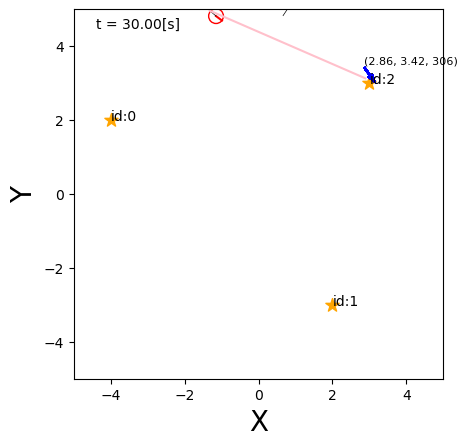

([-0.9607802614094485, 4.69269487219915, 5.847643755554576], [2.9309124318402953, 3.3420233803704877, 5.54103580055553])

In [20]:
trial()